# Lab-P13: Analyzing World Data with SQL

In this lab, you will practice how to:

* write SQL queries,
* create your own plots.

# Segment 1: Setup

### Task 1.1: Import the required modules

We will first import some important modules

In [29]:
# it is considered a good coding practice to place all import statements at the top of the notebook
# please place all your import statements in this cell if you need to import any more modules for this project
import os       # for creating download def
import requests # for creating download def
import sqlite3
import pandas as pd
import matplotlib
import math
import numpy as np # this is *only* for the function get_regression_coeff - do NOT use this module elsewhere

In [30]:
# this ensures that font.size setting remains uniform
%matplotlib inline 
pd.set_option('display.max_colwidth', None)
matplotlib.rcParams["font.size"] = 13 # don't use value > 13! Otherwise your y-axis tick labels will be different.

### Task 1.2: Use the `download` function to download `QSranking.json`

Warning: For the lab and the project, do **not** download the dataset `QSranking.json` manually (you **must** write Python code to download this, as in p12). When we run the autograder, this file `QSranking.json` will not be in the directory. So, unless your `p13.ipynb` downloads this file, you will get a **zero score** on the project. Also, make sure your `download` function includes code to check if the file already exists. The TAs will **manually deduct points** otherwise.

In [31]:
# copy the definition of your 'download' function from p12 here - remember to import the necessary modules
def download(filename, url):
    
    if os.path.exists(filename):
        return (str(filename) + ' already exists!')
    
    r = requests.get(url)
    r.raise_for_status()
    
    content = r.text
    with open(filename, mode='w', encoding='utf-8') as f:
        f.write(content)
    
    return (str(filename) + " created!")

In [32]:
# use the 'download' function to download the data from the webpage
# 'https://git.doit.wisc.edu/cdis/cs/courses/cs220/cs220-f22-projects/-/raw/main/p13/QSranking.json'
# to the file 'QSranking.json'

download("QSranking.json", "https://raw.githubusercontent.com/msyamkumar/cs220-f21-projects/main/p13/QSranking.json")

'QSranking.json already exists!'

### Task 1.3: Create a database called 'rankings.db' out of 'QSRankings.json'

You can review the relevant lecture code [here](https://git.doit.wisc.edu/cdis/cs/courses/cs220/cs220-lecture-material/-/tree/main/f22/meena_lec_notes/lec-32).

In [33]:
# create a database called 'rankings.db' out of 'QSranking.json'

# TODO: load the data from 'QSranking.json' into a variable called 'qs_ranking' using pandas' 'read_json' function
# TODO: connect to 'rankings.db' and save it to a variable called 'conn'

qs_ranking = pd.read_json("QSranking.json") 
conn = sqlite3.connect("rankings.db") 

# write the contents of 'qs_ranking' to the table 'rankings' in the database
qs_ranking.to_sql("rankings", conn, if_exists="replace", index=False)

1201

### Task 1.4: Read all the rows in rankings (the database table)

You'll have to use pandas's `read_sql` function to make a query.

In [34]:
# compute and store the answer in the variable 'rankings', but do NOT display it
# replace the ... with your code

rankings = pd.read_sql("SELECT * FROM rankings", conn)

In [35]:
# run this cell to confirm that your variable has been defined properly

assert len(rankings) == 1201
assert rankings.iloc[0]["country"] == "United States"
assert rankings.iloc[-1]["institution_name"] == "Wake Forest University"

# Segment 2: SQL Practice

In practice, we often are more interested in writing more specific queries about our data. For example, we might be interested in finding institutions in the *United States*, or data collected in the `year` *2018*, or both. With **SQL**, **WHERE** and **AND** clauses can help filter the data accordingly.

Before proceeding with this segment, it is **recommended** that you **review** the relevant lecture code [here](https://git.doit.wisc.edu/cdis/cs/courses/cs220/cs220-lecture-material/-/tree/main/f22/meena_lec_notes/lec-32) and [here](https://git.doit.wisc.edu/cdis/cs/courses/cs220/cs220-lecture-material/-/tree/main/f22/meena_lec_notes/lec-33).

### Task 2.1: Use WHERE to find institutions in the United States

* Write a query to select the rows from the database with *United States* as the `country`.
* Keep only the `institution_name` column.
* Save these institution names to a **list**.

**Hint:** You will need to use **quotes** (`'`) around the **strings** in your query and **backticks** (``` ` ```) around **column names** as in the example below.

In [36]:
# we have done this one for you
def qry(sql, conn):
    return pd.read_sql(sql, conn)
us_institutions_df = pd.read_sql("SELECT `institution_name` \
                                 FROM rankings \
                                 WHERE `country` = 'United States'", conn)
# us_institutions = list(us_institutions_df['institution_name'])

us_institutions_df = qry("""
SELECT institution_name
FROM rankings
WHERE country = "United States"
"""
, conn)

us_institutions = list(us_institutions_df['institution_name'])


In [37]:
# run this cell to confirm that your variable has been defined properly

assert "University Of Wisconsin-Madison" in us_institutions
assert "Tampere University" in list(rankings["institution_name"])
assert "Tampere University" not in us_institutions

### Task 2.2: Add an AND clause to find institutions in the United States with at least 70 overall score

* Copy your query from Task 2.1.
* Update it to only select rows with `overall_score` of **at least** *70*.

In [38]:
# compute and store the answer in the variable 'good_us_institutions', but do NOT display it
# us_institutions_df = pd.read_sql("SELECT `institution_name` FROM rankings WHERE `country` = 'United States'", conn)

good_us_institutions_df = qry("""
SELECT institution_name
FROM rankings
WHERE country = "United States" AND overall_score >= 70
"""
, conn) 

good_us_institutions = list(good_us_institutions_df['institution_name'])


In [39]:
# run this cell to confirm that your variable has been defined properly

assert "Massachusetts Institute Of Technology" in good_us_institutions
assert "University Of Wisconsin-Madison" in good_us_institutions
assert "Wake Forest University" not in good_us_institutions
assert "University of Connecticut" not in good_us_institutions

### Task 2.3: Use an ORDER BY clause to display the top 5 institutions by academic reputation in 2019

In addition to **WHERE** and **AND**, the **ORDER BY** keyword helps organize data even further. Much like the `sort_values()` function in `pandas`, the **ORDER BY** clause can be used to organize the result of the query in *increasing* (**ASC**) or *decreasing* (**DESC**) order based on a column's values.

* Write a new query to select rows in rankings where the `year` is *2019*.
* Use **ORDER BY** and **LIMIT** to select the top 5 rows with the **highest** `academic_reputation`.
* Save these institution names to a **list**.

In [40]:
# compute and store the answer in the variable 'top_5_institutions', then display it

# top_5_institutions_df = pd.read_sql("SELECT `institution_name` FROM rankings WHERE `year` = 2019 ORDER BY `academic_reputation` DESC LIMIT 5", conn)

top_5_institutions_df = qry("""
SELECT institution_name
FROM rankings
WHERE year = 2019
ORDER BY academic_reputation DESC
LIMIT 5
""", conn)

top_5_institutions = list(top_5_institutions_df['institution_name'])

print(top_5_institutions)

['Massachusetts Institute Of Technology', 'Stanford University', 'Harvard University', 'University Of Oxford', 'University Of Cambridge']


In [41]:
# run this cell to confirm that your variable has been defined properly

assert len(top_5_institutions) == 5
assert top_5_institutions[0] == "Massachusetts Institute Of Technology"
assert top_5_institutions[-1] == "University Of Cambridge"

### Task 2.4: Order by multiple columns

If you print out the resulting dataframe from your query, you might notice that all 5 rows have the same academic reputation. This makes it hard to compare the universities, so we will add some **tiebreaking** rules. If two universities have the same `academic_reputation`, then we should order them by their `citations_per_faculty` (with the **highest** appearing first). You can do this by ordering by multiple columns.

* Copy your query from Task 2.3.
* Update the **ORDER BY** clause to add this tiebreaking behavior.
* Save these institution names to a **list**.

In [42]:
# compute and store the answer in the variable 'top_5_with_tiebreak', then display it

# top_5_with_tiebreak_df = pd.read_sql("SELECT `institution_name` FROM rankings WHERE `year` = 2019 ORDER BY `academic_reputation` DESC, `citations_per_faculty` DESC LIMIT 5", conn)
top_5_with_tiebreak_df = qry("""
SELECT institution_name
FROM rankings
WHERE year = 2019
ORDER BY academic_reputation DESC, citations_per_faculty DESC
LIMIT 5

""", conn)

top_5_with_tiebreak = list(top_5_with_tiebreak_df['institution_name'])

print(top_5_with_tiebreak)

['University Of California, Berkeley', 'Massachusetts Institute Of Technology', 'Harvard University', 'Stanford University', 'University Of California, Los Angeles']


In [43]:
# run this cell to confirm that your variable has been defined properly

assert top_5_with_tiebreak[0] == "University Of California, Berkeley"
assert top_5_with_tiebreak[-1] == "University Of California, Los Angeles"

### Task 2.5: Use GROUP BY clause and SUM aggregate function to get the total number of international_students for each country in 2019

The **GROUP BY** keyword groups rows that have the same value. It is often used with aggregate functions, such as **COUNT**, **SUM**, **AVG**, etc. to obtain a summary about groups in the data.

For example, to answer the question "What is the average rank of each country's institutions?", we could **GROUP BY** the `country` and use the **AVG** aggregate function to get the average rank of each country.

* Write a new query that uses **GROUP BY** and **SUM** to get the total number of international students in each country, using **WHERE** to filter by the `year`.
* Save the resulting **DataFrame** with **two** columns: `country` and the **sum** of the `international_students` for that country.

In [44]:
# compute and store the answer in the variable 'inter_students_by_country', then display it
# inter_students_by_country = pd.read_sql("SELECT `country`, SUM(international_students) FROM rankings WHERE `year` = 2019 GROUP BY `country`", conn)

inter_students_by_country = qry("""
SELECT country, SUM(international_students)
FROM rankings
WHERE year = 2019
GROUP BY country

""", conn)
inter_students_by_country

country  SUM(international_students)
0              Argentina                        170.2
1              Australia                       1895.5
2                Austria                        336.1
3                Belarus                         24.4
4                Belgium                        374.0
5                 Brazil                         12.4
6                 Brunei                         65.7
7                 Canada                        957.1
8                  Chile                         13.4
9                  China                        296.9
10              Colombia                          4.6
11        Czech Republic                         47.8
12               Denmark                        207.0
13               Estonia                         20.0
14               Finland                         89.5
15                France                        841.3
16               Germany                       1012.6
17             Hong Kong                        544.1
18                 India                         12.0
19             Indonesia                         10.7
20               Ireland                        261.8
21                Israel                         30.4
22                 Italy                        182.6
23                 Japan                        280.9
24            Kazakhstan                         28.0
25               Lebanon                         67.8
26              Malaysia                        270.3
27                Mexico                         26.1
28           Netherlands                        773.8
29           New Zealand                        550.4
30                Norway                         82.1
31              Pakistan                          1.1
32           Philippines                          1.5
33                Poland                         13.4
34              Portugal                         43.1
35                 Qatar                         99.5
36                Russia                        511.6
37          Saudi Arabia                        111.6
38             Singapore                        164.2
39          South Africa                         57.5
40           South Korea                        341.6
41                 Spain                        278.9
42                Sweden                        294.9
43           Switzerland                        656.7
44                Taiwan                        242.7
45              Thailand                          8.8
46  United Arab Emirates                        219.8
47        United Kingdom                       4275.2
48         United States                       3675.0

In [45]:
# run this cell to confirm that your variable has been defined properly

assert math.isclose(inter_students_by_country[inter_students_by_country["country"] == "Japan"].iloc[0][1], 280.9)
assert math.isclose(inter_students_by_country[inter_students_by_country["country"] == "Australia"].iloc[0][1], 1895.5)
assert math.isclose(inter_students_by_country[inter_students_by_country["country"] == "United States"].iloc[0][1], 3675.0)

### Task 2.6: Use the AS keyword to rename the new column from Task 2.5 to total_international_students

Although the dataframe does have a column for the sum of international students for each country, the name of the column looks strange:

```sql
SUM(`international_students`)
```

In SQL, the **AS** keyword allows us to rename the columns we create with our queries to make the resulting **DataFrame** easier to understand.

* Paste your query from Task 2.5 and modify it so the **SUM** column has the name `total_international_students`.
* Save the resulting **DataFrame** with **two** columns: `country` and `total_international_students`.

In [46]:
# compute and store the answer in the variable 'inter_students_by_country_renamed', then display it
# inter_students_by_country_renamed = pd.read_sql("SELECT `country`, SUM(international_students) AS total_international_students FROM rankings WHERE `year` = 2019 GROUP BY `country`", conn)

inter_students_by_country_renamed = qry("""
SELECT country, SUM(international_students) AS total_international_students
FROM rankings
WHERE year = 2019
GROUP BY country

""", conn)
inter_students_by_country_renamed


country  total_international_students
0              Argentina                         170.2
1              Australia                        1895.5
2                Austria                         336.1
3                Belarus                          24.4
4                Belgium                         374.0
5                 Brazil                          12.4
6                 Brunei                          65.7
7                 Canada                         957.1
8                  Chile                          13.4
9                  China                         296.9
10              Colombia                           4.6
11        Czech Republic                          47.8
12               Denmark                         207.0
13               Estonia                          20.0
14               Finland                          89.5
15                France                         841.3
16               Germany                        1012.6
17             Hong Kong                         544.1
18                 India                          12.0
19             Indonesia                          10.7
20               Ireland                         261.8
21                Israel                          30.4
22                 Italy                         182.6
23                 Japan                         280.9
24            Kazakhstan                          28.0
25               Lebanon                          67.8
26              Malaysia                         270.3
27                Mexico                          26.1
28           Netherlands                         773.8
29           New Zealand                         550.4
30                Norway                          82.1
31              Pakistan                           1.1
32           Philippines                           1.5
33                Poland                          13.4
34              Portugal                          43.1
35                 Qatar                          99.5
36                Russia                         511.6
37          Saudi Arabia                         111.6
38             Singapore                         164.2
39          South Africa                          57.5
40           South Korea                         341.6
41                 Spain                         278.9
42                Sweden                         294.9
43           Switzerland                         656.7
44                Taiwan                         242.7
45              Thailand                           8.8
46  United Arab Emirates                         219.8
47        United Kingdom                        4275.2
48         United States                        3675.0

In [47]:
# run this cell to confirm that your variable has been defined properly

assert "total_international_students" in inter_students_by_country_renamed.columns
assert math.isclose(inter_students_by_country_renamed[inter_students_by_country_renamed["country"] == "Japan"]["total_international_students"], 280.9)
assert math.isclose(inter_students_by_country_renamed[inter_students_by_country_renamed["country"] == "Australia"]["total_international_students"], 1895.5)
assert math.isclose(inter_students_by_country_renamed[inter_students_by_country_renamed["country"] == "United States"]["total_international_students"], 3675.0)

### Task 2.7: Use the HAVING keyword to only keep countries with more than 1000 international students

In addition to **WHERE**, the **HAVING** keyword is useful for filtering **GROUP BY** queries. Whereas **WHERE** filters the number of rows, **HAVING** filters the number of groups.

* Paste your query from Task 2.6 and modify it so that it only returns countries (`country`) and `total_international_students` with **more than** *1000* international students.
* Save the resulting **DataFrame** with **two** columns: `country` and `total_international_students`.


In [48]:
# compute and store the answer in the variable 'inter_students_by_country_more_than_1000', then display it

# inter_students_by_country_renamed = pd.read_sql("SELECT `country`, SUM(international_students) AS total_international_students FROM rankings WHERE `year` = 2019 GROUP BY `country`", conn)

# inter_students_by_country_more_than_1000 = pd.read_sql("SELECT `country`, SUM(international_students) AS total_international_students FROM rankings WHERE `year` = 2019 GROUP BY `country` HAVING total_international_students > 1000", conn)

inter_students_by_country_more_than_1000 = qry("""
SELECT country, SUM(international_students) AS total_international_students
FROM rankings
WHERE year = 2019
GROUP BY country
HAVING total_international_students > 1000

""", conn)

inter_students_by_country_more_than_1000

country  total_international_students
0       Australia                        1895.5
1         Germany                        1012.6
2  United Kingdom                        4275.2
3   United States                        3675.0

In [49]:
# run this cell to confirm that your variable has been defined properly

assert len(inter_students_by_country_more_than_1000) == 4
assert "Australia" in list(inter_students_by_country_more_than_1000["country"])
assert "Germany" in list(inter_students_by_country_more_than_1000["country"])
assert "United Kingdom" in list(inter_students_by_country_more_than_1000["country"])
assert "United States" in list(inter_students_by_country_more_than_1000["country"])

# Segment 3: Plotting

SQL provides powerful tools to manipulate and organize data. Now we might be interested in plotting the data to engage in data exploration and visualize our results.

Before starting this segment, it is recommended that you go through the readings assigned during lecture. You can review the relevant lecture readings [here](https://cs220.cs.wisc.edu/f22/materials/readings/line-and-bar.html) and [here](https://cs220.cs.wisc.edu/f22/materials/readings/matplotlib-intro.html).

### Task 3.1: Use a bar plot to plot the data from Task 2.7

Your plot should look like this:

<div>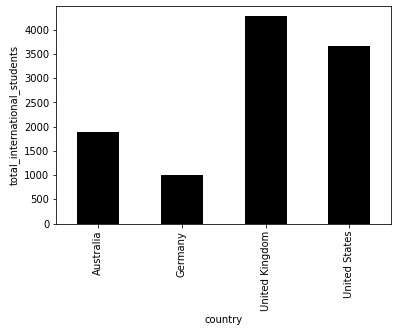</div>

Make sure that the plot is labelled exactly as in the image here.

In [112]:
# instead of specifically plotting just the DataFrame 'inter_students_by_country_more_than_1000',
# create a general function to create bar plots

def bar_plot(df, x, y):
    """bar_plot(df, x, y) takes in a DataFrame 'df' and displays 
    a bar plot with the column 'x' as the x-axis, and the column
    'y' as the y-axis"""
    
    
    df = df.set_index(x)            # set dataframe index to 'x'
    df.plot.bar(color = 'k', legend=False)   # use df.plot.bar to plot the data in black with no legend

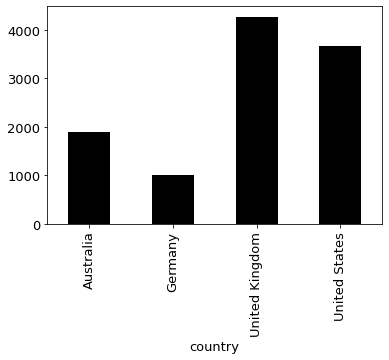

In [113]:
# run this cell to plot the data from Task 2.7
# verify that this plot matches exactly with the image shown above

bar_plot(inter_students_by_country_more_than_1000, 'country', 'total_international_students')

### Task 3.2: Use a scatter plot to plot the relationship between employer_reputation and academic_reputation in 2019

Your plot should look like this:

<div>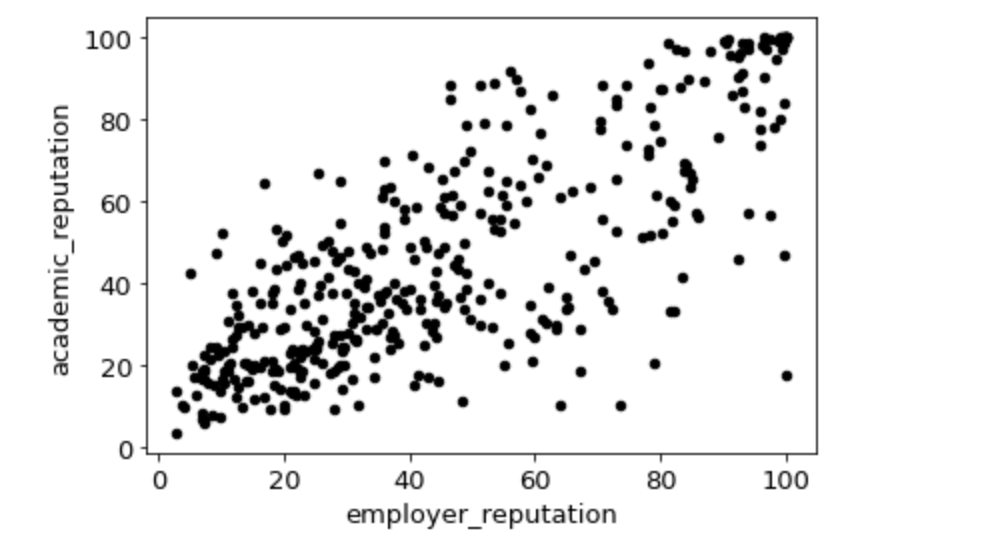</div>

Make sure that the plot is labelled exactly as in the image here.

In [114]:
# create a general function to create scatter plots

def scatter_plot(df, x, y):
    """scatter_plot(df, x, y) takes in a DataFrame 'df' and displays 
    a scatter plot with the column 'x' as the x-axis, and the column
    'y' as the y-axis"""
    
    
    # TODO: use df.plot.scatter to plot the data in black with no legend
    df.plot.scatter(x, y, color = 'k')
    # TODO: set x as the x label 
    # TODO: set y as the y label
    # TODO: set the color to black


With the `scatter_plot` function defined, you are ready to create the required plot.

* Write a SQL query to select rows from the database where the `year` is *2019*.
* Save the resulting **DataFrame** with **two** columns: `employer_reputation` and `academic_reputation`.
* Call `scatter_plot`, passing in `employer_reputation` and `academic_reputation` as the `x` and `y` arguments.

In [116]:
# first compute and store the DataFrame
# then create the scatter plot using the DataFrame
# verify that this plot matches exactly with the image shown above
query = """
SELECT employer_reputation, academic_reputation
FROM rankings
WHERE year = 2019
"""
df = pd.read_sql(query, conn)

scatter_plot(df, "employer_reputation", "academic_reputation")

### Task 3.3: Make a Horizontal Bar plot of average employer_reputation and average faculty_student_score across all years

Your plot should look like this:

<div>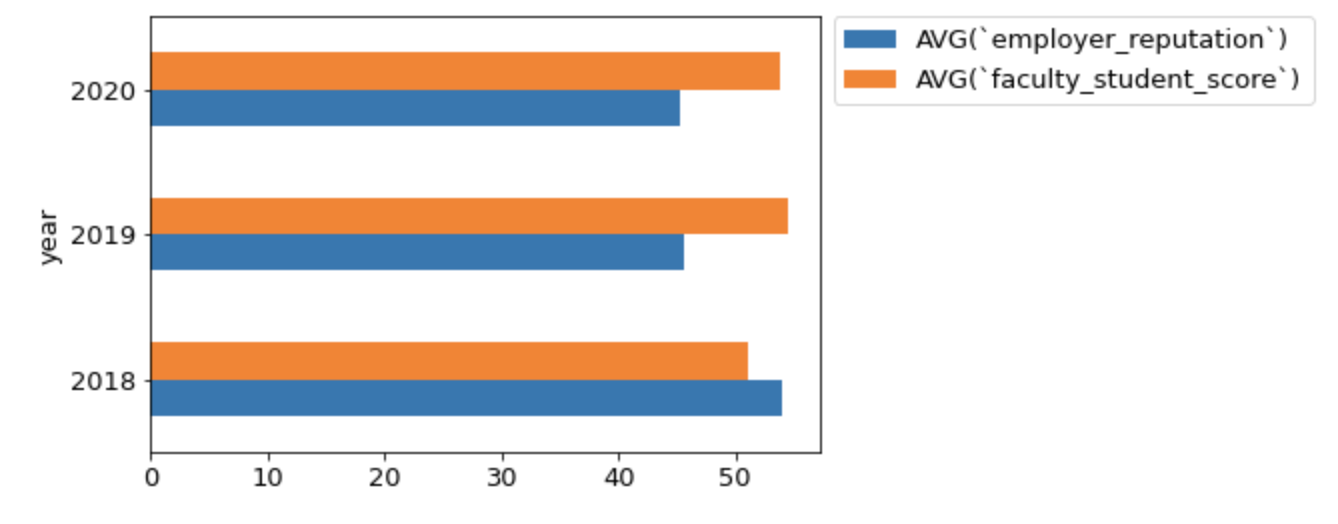</div>

Make sure that the plot is labelled exactly as in the image here.

In [117]:
# we have done this one for you

def horizontal_bar_plot(df, x):
    """horizontal_bar_plot(df, x) takes in a DataFrame 'df' and displays 
    a horizontal bar plot with the column 'x' as the x-axis, and all
    other columns of 'df' on the y-axis"""
    df = df.set_index(x)
    ax = df.plot.barh()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.9))

Use the `horizontal_bar_plot` function to create the required plot.

* Write a SQL query to select `year`, **average** `employer_reputation`, and **average** `faculty_student_score` grouped by `year`.
* Save the resulting **DataFrame** with **three** columns: `year`, the **average** of the `employer_reputation` and the **average** of the `faculty_student_score`.
* Call `horizontal_bar_plot`, passing in `year` as the `x` argument.

In [55]:
# first compute and store the DataFrame
# then create the horizontal bar plot using the DataFrame
# verify that this plot matches exactly with the image shown above
horizontal_bar_plot()

### Task 3.4 Display a Pie Chart of the average overall score of the top 10 countries in descending order

Your plot should look like this:

<div>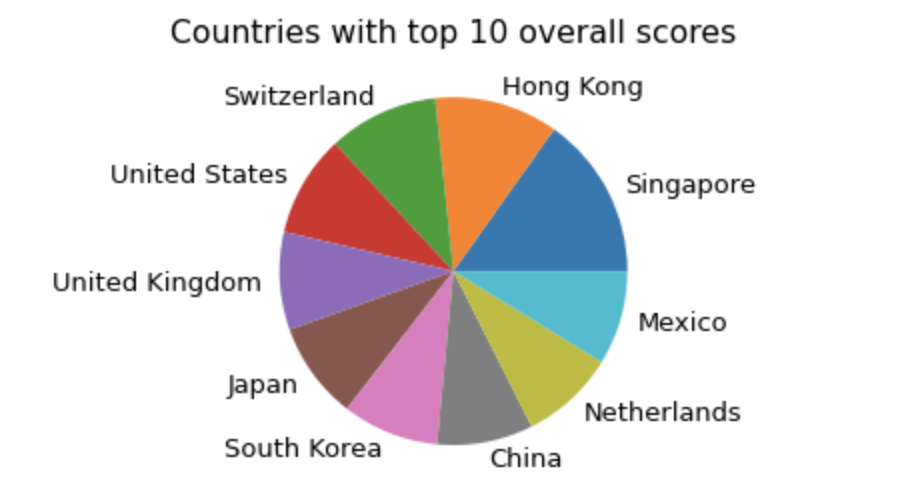</div>

Make sure that the plot is labelled exactly as in the image here. Your plot must also have the **title** `Countries with top 10 overall scores` as in the image.

In [56]:
# we have done this one for you

def pie_plot(df, x, y, title=None):
    """pie_plot(df, x, y, title) takes in a DataFrame 'df' and displays 
    a pie plot with the column 'x' as the x-axis, the (numeric) column
    'y' as the y-axis, and the 'title' as the title of the plot"""
    df = df.set_index(x)
    ax = df.plot.pie(y=y, legend=False)
    ax.set_ylabel(None)
    ax.set_title(title)

Use the `pie_plot` function to create the required plot.

* Write a SQL query to select the **top** *10* countries based on **average** `overall_score`.
* Save the resulting **DataFrame** with **two** columns: `country`, and the **average** of the `overall_score`.
* Call `pie_plot`, passing in `country` as the `x` argument, and the **average** of the `overall_score` as the `y` argument.

**Hint:** If you are having trouble writing the SQL query, take a look at Task 2.3

In [57]:
# first compute and store the DataFrame
# then create the pie plot using the DataFrame
# verify that this plot matches exactly with the image shown above


### Task 3.5: Fit a regression line to the data from Task 3.2

Your line of best fit should look like this:

<div>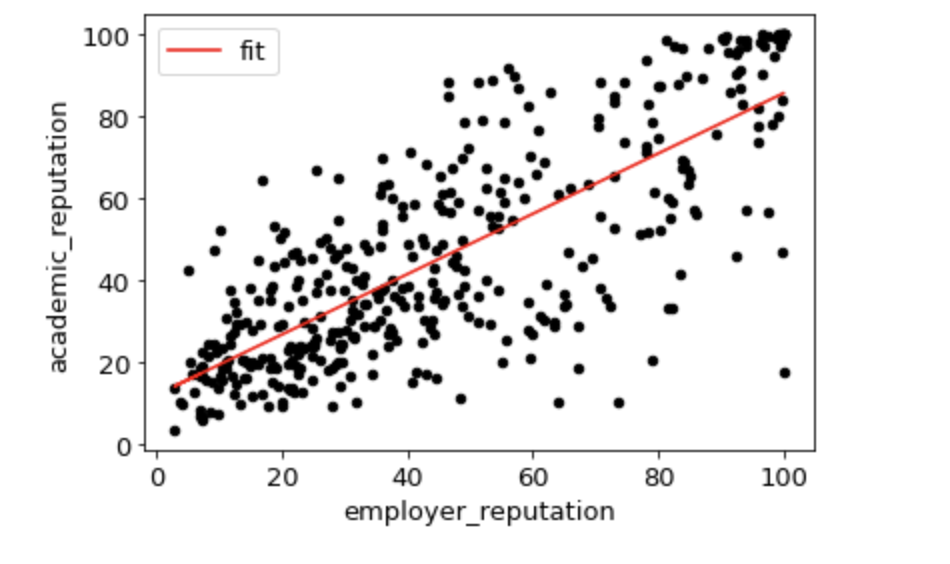</div>
    
Make sure that the plot is labelled exactly as in the image here.

In [58]:
# we have defined this function for you

def get_regression_coeff(df, x, y):
    """get_regression_coeff(df, x, y) takes in a DataFrame 'df' and returns 
    the slope (m) and the y-intercept (b) of the line of best fit in the
    plot with the column 'x' as the x-axis, and the column 'y' as the y-axis"""
    df["1"] = 1
    res = np.linalg.lstsq(df[[x, "1"]], df[y], rcond=None) #least square 
    coefficients = res[0]
    m = coefficients[0]  # Y = mx + b
    b = coefficients[1]
    return (m, b)

In [59]:
# you must define this function to plot the best fit line on the scatter plot

def regression_line_plot(df, x, y):
    """regression_line_plot(df, x, y) takes in a DataFrame 'df' and displays
    a scatter plot with the column 'x' as the x-axis, and the column
    'y' as the y-axis, as well as the best fit line for the plot"""
    m, b = get_regression_coeff(df, x, y)
    ax = df.plot.scatter()
    return ax
    pass # replace with your code
    # TODO: use the 'get_regression_coeff' function to get the slope and
    #       intercept of the line of best fit
    # TODO: save them into variables m and b respectively
    
    # TODO: use df.plot.scatter (not scatter_plot) to plot the x and y columns
    #       of 'df' in black color.
    # TODO: save the return value of df.plot.scatter to a variable called 'ax'
    
    # TODO: create a new column in the dataframe called 'fit', which is
    #       is calculated as df['fit'] = m * df[x] + b
    
    # TODO: use df.plot.line to plot the fitted line in red,
    #       using ax=ax as a keyword argument.
    #       this ensures that both the scatter plot and line end up on the same plot
    #       play careful attention to what the 'x' and 'y' arguments ought to be

Now, use the `regression_line_plot` function to create the required plot.

* Call `regression_line_plot` on your data from Task 3.2 to show the correlation between `employer_reputation` and `academic_reputation`.

In [60]:
# create the scatter plot with the best fit line using the DataFrame from Task 3.2 
# verify that this plot matches exactly with the image shown above


### Congratulations, you are now ready to start p13!